# KQL Nexus

KQL Nexus is a Flask-based application designed to integrate KQL (Kusto Query Language) queries with advanced language models and vector databases. It provides a user-friendly interface for uploading documents, processing URLs, executing KQL queries, and interacting with a tuned language model for summarization and insights.

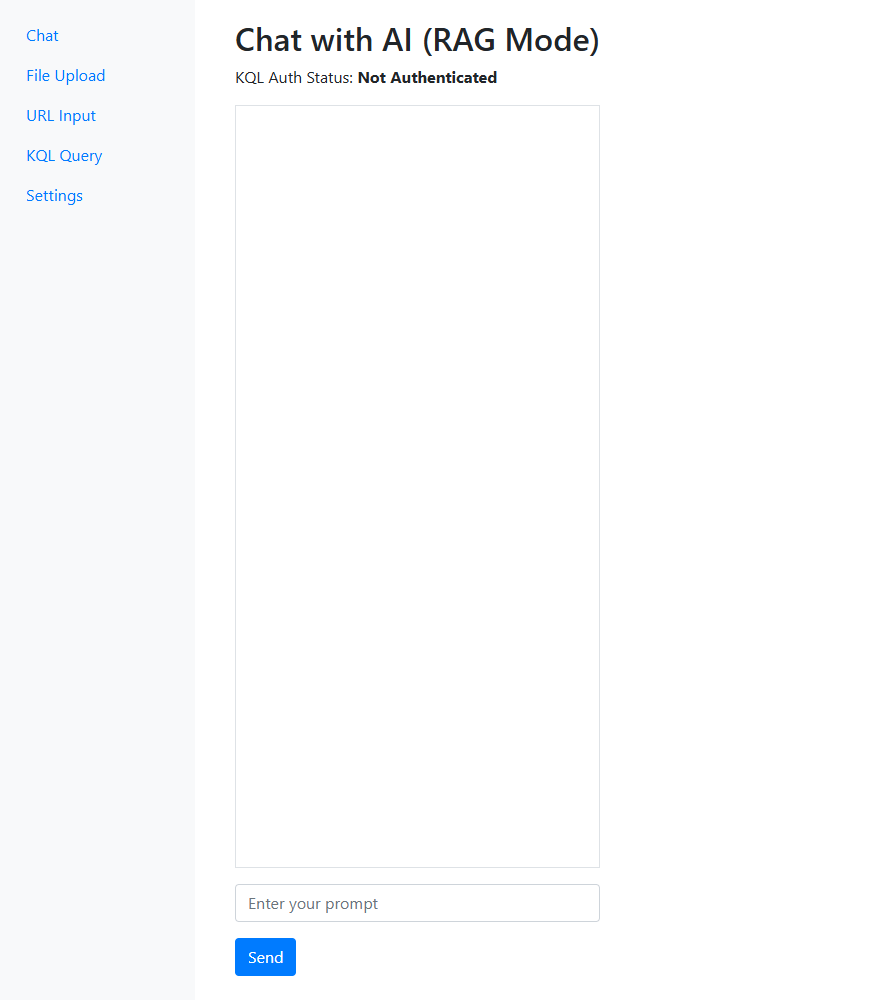


## Features

- **KQL Query Execution**: Execute KQL queries against Azure Data Explorer clusters and retrieve results.
- **KQL Query Summarization**: Generate summaries and numerical insights for KQL query results using a tuned language model.
- **Document Ingestion**: Upload files (PDF, CSV, or plain text) or URLs, process their content, and index them into a vector database for retrieval.
- **Vector Database Integration**: Store and retrieve document embeddings using FAISS (Facebook AI Similarity Search).
- **Custom Embedding Model**: Use a custom embedding model for generating vector representations of text.
- **Chat Interface**: Interact with a tuned language model for conversational AI and context-aware responses.
- **Caching**: Cache embeddings and query results for improved performance.
- **KQL Authentication**: Authenticate with Azure CLI for secure KQL query execution.

## Requirements

To run this project, you need the following dependencies:

- Python 3.8 or higher
- Flask
- Flask-Caching
- Requests
- Pandas
- PyPDF2
- BeautifulSoup4
- Azure Kusto Data SDK
- LangChain
- FAISS (CPU version)
- OpenAI Python SDK

Install the required dependencies using the following command:

```bash
pip install flask flask-caching requests pandas PyPDF2 beautifulsoup4 azure-kusto-data langchain faiss-cpu openai

## Configuring the LM Model

In the current setup, the application uses a locally hosted language model (`hermes-3-llama-3.2-3b`) accessible via a local endpoint (`http://{Server_Ip}:1234`). However, you can easily switch to using OpenAI's API by following these steps:

### Step 1: Obtain OpenAI API Key
- Sign up or log in to your [OpenAI account](https://platform.openai.com/api-keys).
- Generate a new API key from the dashboard.

### Step 2: Set Up Environment Variable
Set your OpenAI API key as an environment variable in your system or directly in your notebook:

```bash
export OPENAI_API_KEY='your-api-key-here'
```

Alternatively, in Python:

```python
import os
os.environ["OPENAI_API_KEY"] = "your-api-key-here"
```

### Step 3: Update LM Model Configuration
Modify the `LM_Model` variable in your code to use an OpenAI model, for example:

```python
LM_Model = 'gpt-3.5-turbo'
```

### Step 4: Update the API Endpoint
Update the `send_request_to_model` function to use OpenAI's official API endpoint. For example:

```python
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")

def send_request_to_model(prompt, model=LM_Model):
    response = openai.ChatCompletion.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    return response
```

### Notes:
- Ensure the `openai` Python package is installed (`pip install openai`).
- Always keep your API key secure and avoid exposing it publicly.
- Adjust the model name (`gpt-3.5-turbo`, `gpt-4`, etc.) based on your requirements and available access.

In [ ]:
#install requirements 

!pip install flask flask-caching requests pandas PyPDF2 beautifulsoup4 azure-kusto-data langchain faiss-cpu openai


In [ ]:
import os
import json
import threading
import requests
import pandas as pd
import PyPDF2
import subprocess
import platform
from bs4 import BeautifulSoup
from flask import Flask, render_template, request, jsonify, redirect
from azure.kusto.data import KustoClient, KustoConnectionStringBuilder
from typing import List
from langchain.embeddings.base import Embeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import CharacterTextSplitter
from langchain.llms import OpenAI  # Adjust as needed
from flask_caching import Cache

# Create Flask app with a dynamic secret key.
app = Flask(__name__)
app.secret_key = os.urandom(24)

# Configure caching (here using SimpleCache; for production, use Redis or similar)
cache = Cache(app, config={'CACHE_TYPE': 'SimpleCache', 'CACHE_DEFAULT_TIMEOUT': 300})

# Global variables for configuration.
LM_Model = 'hermes-3-llama-3.2-3b'
Embeddings_model = 'text-embedding-nomic-embed-text-v1.5'
Server_Ip = '127.0.0.1' # Update with your server IP or hostname.

# ---------------------------
# Custom Embedding Setup with Caching
# ---------------------------
class CustomLocalEmbedding(Embeddings):
    def __init__(self, endpoint_url=f'http://{Server_Ip}:1234/v1/embeddings', model_name=Embeddings_model):
        self.endpoint_url = endpoint_url
        self.model_name = model_name

    @cache.memoize()
    def embed_query(self, text: str) -> List[float]:
        payload = {"model": self.model_name, "input": text}
        headers = {"Content-Type": "application/json"}
        response = requests.post(self.endpoint_url, json=payload, headers=headers)
        if response.status_code == 200:
            data = response.json()
            if "data" in data and isinstance(data["data"], list) and len(data["data"]) > 0:
                if "embedding" in data["data"][0]:
                    return data["data"][0]["embedding"]
            elif "embedding" in data:
                return data["embedding"]
            else:
                raise ValueError("Unexpected response structure: " + str(data))
        else:
            raise Exception(f"Embedding request failed: {response.status_code} {response.text}")

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        return [self.embed_query(text) for text in texts]

embedding_model = CustomLocalEmbedding()
text_splitter = CharacterTextSplitter(separator="\n", chunk_size=500, chunk_overlap=50)

# ---------------------------
# Global Settings
# ---------------------------
settings = {
    "vector_db_location": "vector_db"  # Folder for storing the FAISS index.
}

# Global flag for KQL authentication.
kql_authenticated = False

# In-memory chat history.
chat_history = {"default": []}

# Global vector store variable.
vector_store = None
if os.path.exists(settings['vector_db_location']):
    try:
        vector_store = FAISS.load_local(settings['vector_db_location'], embedding_model)
        print("Loaded vector store from disk.")
    except Exception as e:
        print("Error loading vector store:", e)

def add_document_to_vector_db(doc_text, metadata=None):
    global vector_store
    docs = text_splitter.split_text(doc_text)
    from langchain.docstore.document import Document
    documents = [Document(page_content=chunk, metadata=metadata or {}) for chunk in docs]
    if vector_store is None:
        vector_store = FAISS.from_documents(documents, embedding_model)
    else:
        vector_store.add_documents(documents)
    vector_store.save_local(settings['vector_db_location'])
    return "Document indexed successfully."

# ---------------------------
# LM Model Interaction Functions
# ---------------------------
def send_request_to_model(prompt, model=LM_Model):
    url = f"http://{Server_Ip}:1234/v1/chat/completions"
    headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer YOUR_API_KEY"  # Update with your actual API key.
    }
    payload = {
        "model": model,
        "messages": [{"role": "user", "content": prompt}]
    }
    response = requests.post(url, headers=headers, json=payload)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} {response.reason}")
        return None

def send_request_to_tuned_model(prompt, context=None):
    full_prompt = prompt + (("\n\nContext:\n" + context) if context else "")
    return send_request_to_model(full_prompt, model="tuned-hermes-3-llama-3.2-3b")

# ---------------------------
# Document & URL Processing Functions
# ---------------------------
def process_uploaded_file(file_path):
    ext = os.path.splitext(file_path)[1].lower()
    if ext == '.pdf':
        text = ""
        with open(file_path, 'rb') as f:
            reader = PyPDF2.PdfReader(f)
            for page in reader.pages:
                text += page.extract_text() or ""
        return text
    elif ext == '.csv':
        try:
            df = pd.read_csv(file_path)
            return df.to_html(classes="table table-striped")
        except Exception as e:
            return f"Error processing CSV: {e}"
    else:
        try:
            with open(file_path, 'r', encoding="utf8") as f:
                return f.read()
        except Exception as e:
            return f"Error reading file: {e}"

def process_url_content(url):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        return soup.get_text(separator="\n")
    except Exception as e:
        return f"Error fetching URL: {e}"

# ---------------------------
# KQL Query Functions with Caching for Similar Queries
# ---------------------------
def generate_kql_explanation(query, results):
    results_text = json.dumps(results, indent=2, default=str)
    prompt = f"Summarize the following KQL query results and provide numerical insights:\nQuery: {query}\nResults:\n{results_text}"
    response = send_request_to_model(prompt, model="tuned-hermes-3-llama-3.2-3b")
    if response and 'choices' in response and response['choices']:
        return response['choices'][0]['message']['content']
    else:
        return "No summary available."

def execute_kql_query(query):
    import re
    cluster_match = re.search(r"cluster\('([^']+)'\)", query)
    if not cluster_match:
        raise ValueError("Could not extract cluster from query.")
    database_match = re.search(r"database\('([^']+)'\)", query)
    if not database_match:
        raise ValueError("Could not extract database from query.")
    cluster = "https://" + cluster_match.group(1)
    database = database_match.group(1)
    cleaned_query = re.sub(r"cluster\('([^']+)'\)\.database\('([^']+)'\)\.", "", query)
    kcsb = KustoConnectionStringBuilder.with_az_cli_authentication(cluster)
    client = KustoClient(kcsb)
    response = client.execute(database, cleaned_query)
    results = []
    columns = [col.column_name for col in response.primary_results[0].columns]
    for row in response.primary_results[0]:
        results.append(dict(zip(columns, row)))
    return results

# ---------------------------
# KQL Authentication Route (Using Azure CLI)
# ---------------------------
def check_az_cli_auth():
    az_command = "az.cmd" if platform.system() == "Windows" else "az"
    try:
        result = subprocess.run([az_command, "account", "get-access-token"], capture_output=True, text=True)
        if result.returncode == 0:
            return True, result.stdout
        else:
            return False, result.stderr
    except Exception as e:
        return False, str(e)

@app.route('/kql_auth', methods=['POST'])
def kql_auth():
    global kql_authenticated
    success, message = check_az_cli_auth()
    if success:
        kql_authenticated = True
        return jsonify({'status': 'Authenticated', 'message': message})
    else:
        kql_authenticated = False
        return jsonify({'status': 'Not Authenticated', 'message': message})

# ---------------------------
# Route: Ingest KQL Results into Vector DB
# ---------------------------
@app.route('/ingest_kql', methods=['POST'])
def ingest_kql():
    query = request.form.get('query', '')
    summary = request.form.get('summary', '')
    text_to_index = f"KQL Ingestion: Query: {query}\nSummary: {summary}"
    message = add_document_to_vector_db(text_to_index, metadata={"source": "KQL Ingestion"})
    return jsonify({'message': message})

# ---------------------------
# Vector DB Information Route
# ---------------------------
@app.route('/vector_info', methods=['GET'])
def vector_info():
    vector_db_dir = settings.get('vector_db_location', 'vector_db')
    files_info = []
    if os.path.exists(vector_db_dir):
        for f in os.listdir(vector_db_dir):
            file_path = os.path.join(vector_db_dir, f)
            if os.path.isfile(file_path):
                size = os.path.getsize(file_path)
                files_info.append({"filename": f, "size": size})
        status = "Exists"
        count = vector_store.index.ntotal if vector_store is not None and hasattr(vector_store.index, 'ntotal') else "Unknown"
    else:
        status = "Not Initialized"
        count = 0
    return jsonify({
        'vector_db_status': status,
        'document_count': count,
        'vector_db_location': os.path.abspath(vector_db_dir),
        'files': files_info
    })

# ---------------------------
# Main Routes
# ---------------------------
@app.route('/')
def index():
    return render_template('index.html', chat_history=chat_history.get("default", []), kql_auth_status=("Authenticated" if kql_authenticated else "Not Authenticated"))

@app.route('/chat', methods=['POST'])
def chat():
    prompt = request.form['prompt']
    context = ""
    if vector_store is not None:
        retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 5})
        retrieved_docs = retriever.get_relevant_documents(prompt)
        if retrieved_docs:
            context = "\n".join([doc.page_content for doc in retrieved_docs])
        else:
            context = "No relevant context found in vector DB."
    response = send_request_to_tuned_model(prompt, context=context)
    if response and 'choices' in response and response['choices']:
        result = response['choices'][0]['message']['content']
        chat_history.setdefault("default", []).append({"prompt": prompt, "response": result})
        return jsonify({'prompt': prompt, 'response': result})
    else:
        return jsonify({'error': 'Error communicating with tuned LM model.'})

@app.route('/upload', methods=['POST'])
def upload():
    if 'file' not in request.files:
        return jsonify({'error': 'No file part in the request.'})
    file = request.files['file']
    if file.filename == '':
        return jsonify({'error': 'No file selected.'})
    uploads_dir = 'uploads'
    if not os.path.exists(uploads_dir):
        os.makedirs(uploads_dir)
    file_path = os.path.join(uploads_dir, file.filename)
    file.save(file_path)
    processed_content = process_uploaded_file(file_path)
    index_message = add_document_to_vector_db(processed_content, metadata={"source": file.filename})
    return jsonify({'file': file.filename, 'content': processed_content, 'message': index_message})

@app.route('/upload_url', methods=['POST'])
def upload_url():
    url_input = request.form['url']
    content = process_url_content(url_input)
    index_message = add_document_to_vector_db(content, metadata={"source": url_input})
    return jsonify({'url': url_input, 'content': content, 'message': index_message})

@app.route('/kql', methods=['POST'])
def kql():
    query = request.form['query']
    try:
        results = execute_kql_query(query)
        if results:
            df = pd.DataFrame(results)
            table_html = df.to_html(classes="table table-striped", index=False)
        else:
            table_html = "<p>No results returned.</p>"
        results_text = json.dumps(results, indent=2, default=str)
        summary_response = send_request_to_tuned_model("Summarize the following KQL query results and provide numerical insights:\n" + results_text)
        if summary_response and 'choices' in summary_response and summary_response['choices']:
            summary = summary_response['choices'][0]['message']['content']
        else:
            summary = "No summary available."
        return jsonify({'query': query, 'table_html': table_html, 'summary': summary, 'results': results})
    except Exception as e:
        return jsonify({'error': str(e)})

@app.route('/settings', methods=['GET'])
def settings_page():
    return render_template('settings.html', kql_auth_status=("Authenticated" if kql_authenticated else "Not Authenticated"))

# ---------------------------
# Auto-Open Browser (Optional)
# ---------------------------
def open_browser():
    import webbrowser
    webbrowser.open_new('http://127.0.0.1:5000/')

if __name__ == '__main__':
    if not os.path.exists('uploads'):
        os.makedirs('uploads')
    if not os.path.exists(settings['vector_db_location']):
        os.makedirs(settings['vector_db_location'])
    threading.Timer(1, open_browser).start()
    app.run(port=5000, debug=True, use_reloader=False)
